# 1. Data Understanding 

<font size="3"> The goal of this competition is to predict the age of abalone from physical measurements using various regression models.  The abalone's age is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope. We will be looking at numerous physical attributes to determine what the best predictors of age are. </font>

**PHYSICAL ATTRIBUTES**
1. **SEX:** <font size="3"> Male/Female/Infant</font>
2. **LENGTH:** <font size="3"> Longest shell measurement</font>
3. **DIAMETER:** <font size="3"> Diameter of the Abalone</font>
4. **HEIGHT:** <font size="3"> Height of the Abalone</font>
5. **WHOLE WEIGHT:** <font size="3"> Weight of the whole abalone</font>
6. **SHUCKED WEIGHT:** <font size="3"> Weight of the meat</font>
7. **VISCERA WEIGHT:** <font size="3"> Gut Weight - Interal Organs</font>
8. **SHELL WEIGHT:** <font size="3"> Shell Weight after drying</font>
9. **RINGS:** <font size="3"> Number of rings +1.5 gives Age of the Abalone</font>

**EVALUATION METRIC:** <font size="3"> The evaluation metric for this competition is Root Mean Squared Logarithmic Error. </font>

**ORIGINAL DATA:** The original data is sourced from the [site](https://archive.ics.uci.edu/dataset/1/abalone), however, data used in this analysis is from the kaggle website at [site] (https://www.kaggle.com/competitions/playground-series-s4e4/overview).

**SUBMISSION FILE:** For each id row in the test set, we must predict the target, Rings. The file should contain a header and have the following format:

id,Rings

90615,10

90616,10

90617,10

etc.

# 2. Import Packages 

In [1]:
# Import and view the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits import mplot3d
from sklearn.feature_selection import r_regression
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import OLSInfluence

# 3. Load Data 

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [3]:

train= pd.read_csv('../input/playground-series-s4e4/train.csv')
test= pd.read_csv('../input/playground-series-s4e4/test.csv')

train_copy=train.copy()
test_copy=test.copy()

train=train.rename(columns={'Whole weight':'Whole_weight','Whole weight.1':'Shucked_weight', 'Whole weight.2':'Viscera_weight', 'Shell weight':'Shell_weight'})
test=test.rename(columns={'Whole weight':'Whole_weight','Whole weight.1':'Shucked_weight', 'Whole weight.2':'Viscera_weight', 'Shell weight':'Shell_weight'})

# Drop ID from training dataset 
train = train.drop('id', axis=1)

# change data types 
predict_col = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
train[predict_col] = train[predict_col].astype('float64')

target = ['Rings']
train[target] = train[target].astype('int64')

test[predict_col] = test[predict_col].astype('float64')



In [4]:
train.head()

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   F   0.550     0.430   0.150        0.7715          0.3285          0.1465   
1   F   0.630     0.490   0.145        1.1300          0.4580          0.2765   
2   I   0.160     0.110   0.025        0.0210          0.0055          0.0030   
3   M   0.595     0.475   0.150        0.9145          0.3755          0.2055   
4   I   0.555     0.425   0.130        0.7820          0.3695          0.1600   

   Shell_weight  Rings  
0        0.2400     11  
1        0.3200     11  
2        0.0050      6  
3        0.2500     10  
4        0.1975      9

In [5]:
test.head()

id Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0  90615   M   0.645     0.475   0.155        1.2380          0.6185   
1  90616   M   0.580     0.460   0.160        0.9830          0.4785   
2  90617   M   0.560     0.420   0.140        0.8395          0.3525   
3  90618   M   0.570     0.490   0.145        0.8740          0.3525   
4  90619   I   0.415     0.325   0.110        0.3580          0.1575   

   Viscera_weight  Shell_weight  
0          0.3125        0.3005  
1          0.2195        0.2750  
2          0.1845        0.2405  
3          0.1865        0.2350  
4          0.0670        0.1050

# 4. Check for missing values 

In [6]:
# Check the info for the Train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole_weight    90615 non-null  float64
 5   Shucked_weight  90615 non-null  float64
 6   Viscera_weight  90615 non-null  float64
 7   Shell_weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.2+ MB


In [7]:
# Check the info for the Test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60411 entries, 0 to 60410
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              60411 non-null  int64  
 1   Sex             60411 non-null  object 
 2   Length          60411 non-null  float64
 3   Diameter        60411 non-null  float64
 4   Height          60411 non-null  float64
 5   Whole_weight    60411 non-null  float64
 6   Shucked_weight  60411 non-null  float64
 7   Viscera_weight  60411 non-null  float64
 8   Shell_weight    60411 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.1+ MB


In [8]:
# Check the shape of the Train dataset 
print(train.shape)

(90615, 9)


In [9]:
# Check the shape of the Test dataset 
print(test.shape)

(60411, 9)


In [10]:
# Check for 0 or below 0 values Train
(train == 0).sum()

Sex               0
Length            0
Diameter          0
Height            6
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [11]:
# Drop columns with a value of 0 
train = train[~(train == 0).any(axis=1)]

In [12]:
# Check the shape of the Train dataset 
print(train.shape)

(90609, 9)


In [13]:
# Check for negative values 
(train[predict_col] < 0).sum()


Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
dtype: int64

# 5. Exploratory Data Analysis 

## 5.1 Look at training ring distributions

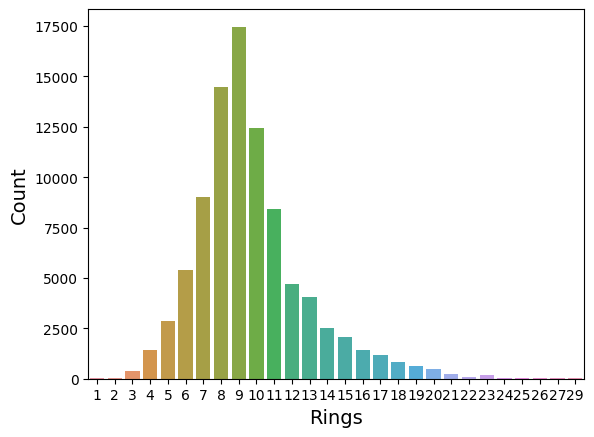

In [14]:
p = sns.countplot(data=train, x='Rings')
p.set_xlabel('Rings', fontsize=14)
p.set_ylabel('Count', fontsize=14)
plt.show()

## 5.2 Create a histogram to see distribution of data between train and test 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

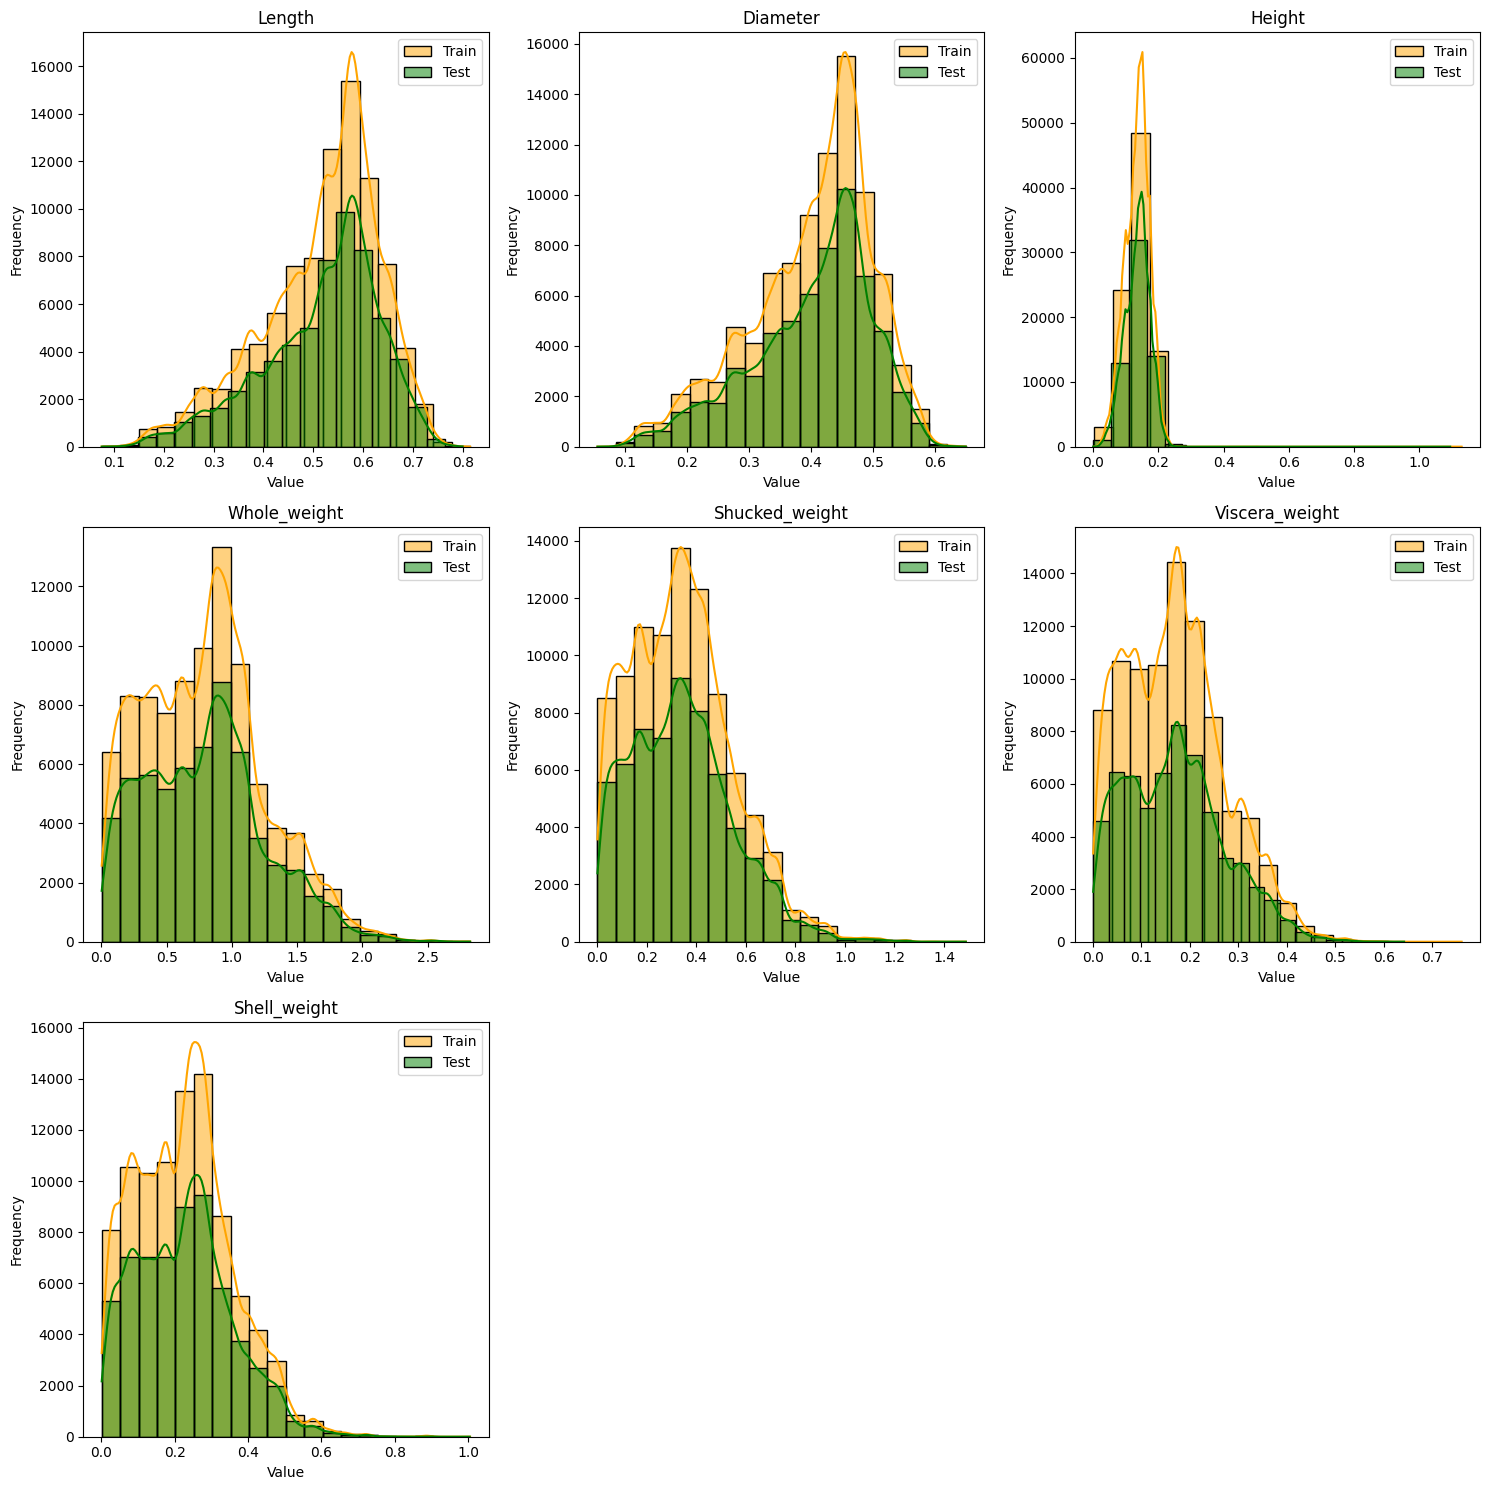

In [15]:
cont_cols = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

# Calculate the number of rows needed for the subplots
num_rows = (len(cont_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Loop through each continuous column and plot the histograms
for i, col in enumerate(cont_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val
    
    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins_train = round(range_val / bin_size)
    num_bins_test = round(range_val / bin_size)
    
    # Calculate the subplot position
    row = i // 3
    col_pos = i % 3
    
    # Plot the histograms
    sns.histplot(train[col], ax=axs[row][col_pos], color='orange', kde=True, label='Train', bins=num_bins_train)
    sns.histplot(test[col], ax=axs[row][col_pos], color='green', kde=True, label='Test', bins=num_bins_test)
    axs[row][col_pos].set_title(col)
    axs[row][col_pos].set_xlabel('Value')
    axs[row][col_pos].set_ylabel('Frequency')
    axs[row][col_pos].legend()

# Remove any empty subplots
if len(cont_cols) % 3 != 0:
    for col_pos in range(len(cont_cols) % 3, 3):
        axs[-1][col_pos].remove()

plt.tight_layout()
plt.show()

## 5.3 Plot the target value by sex against numerical variables 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

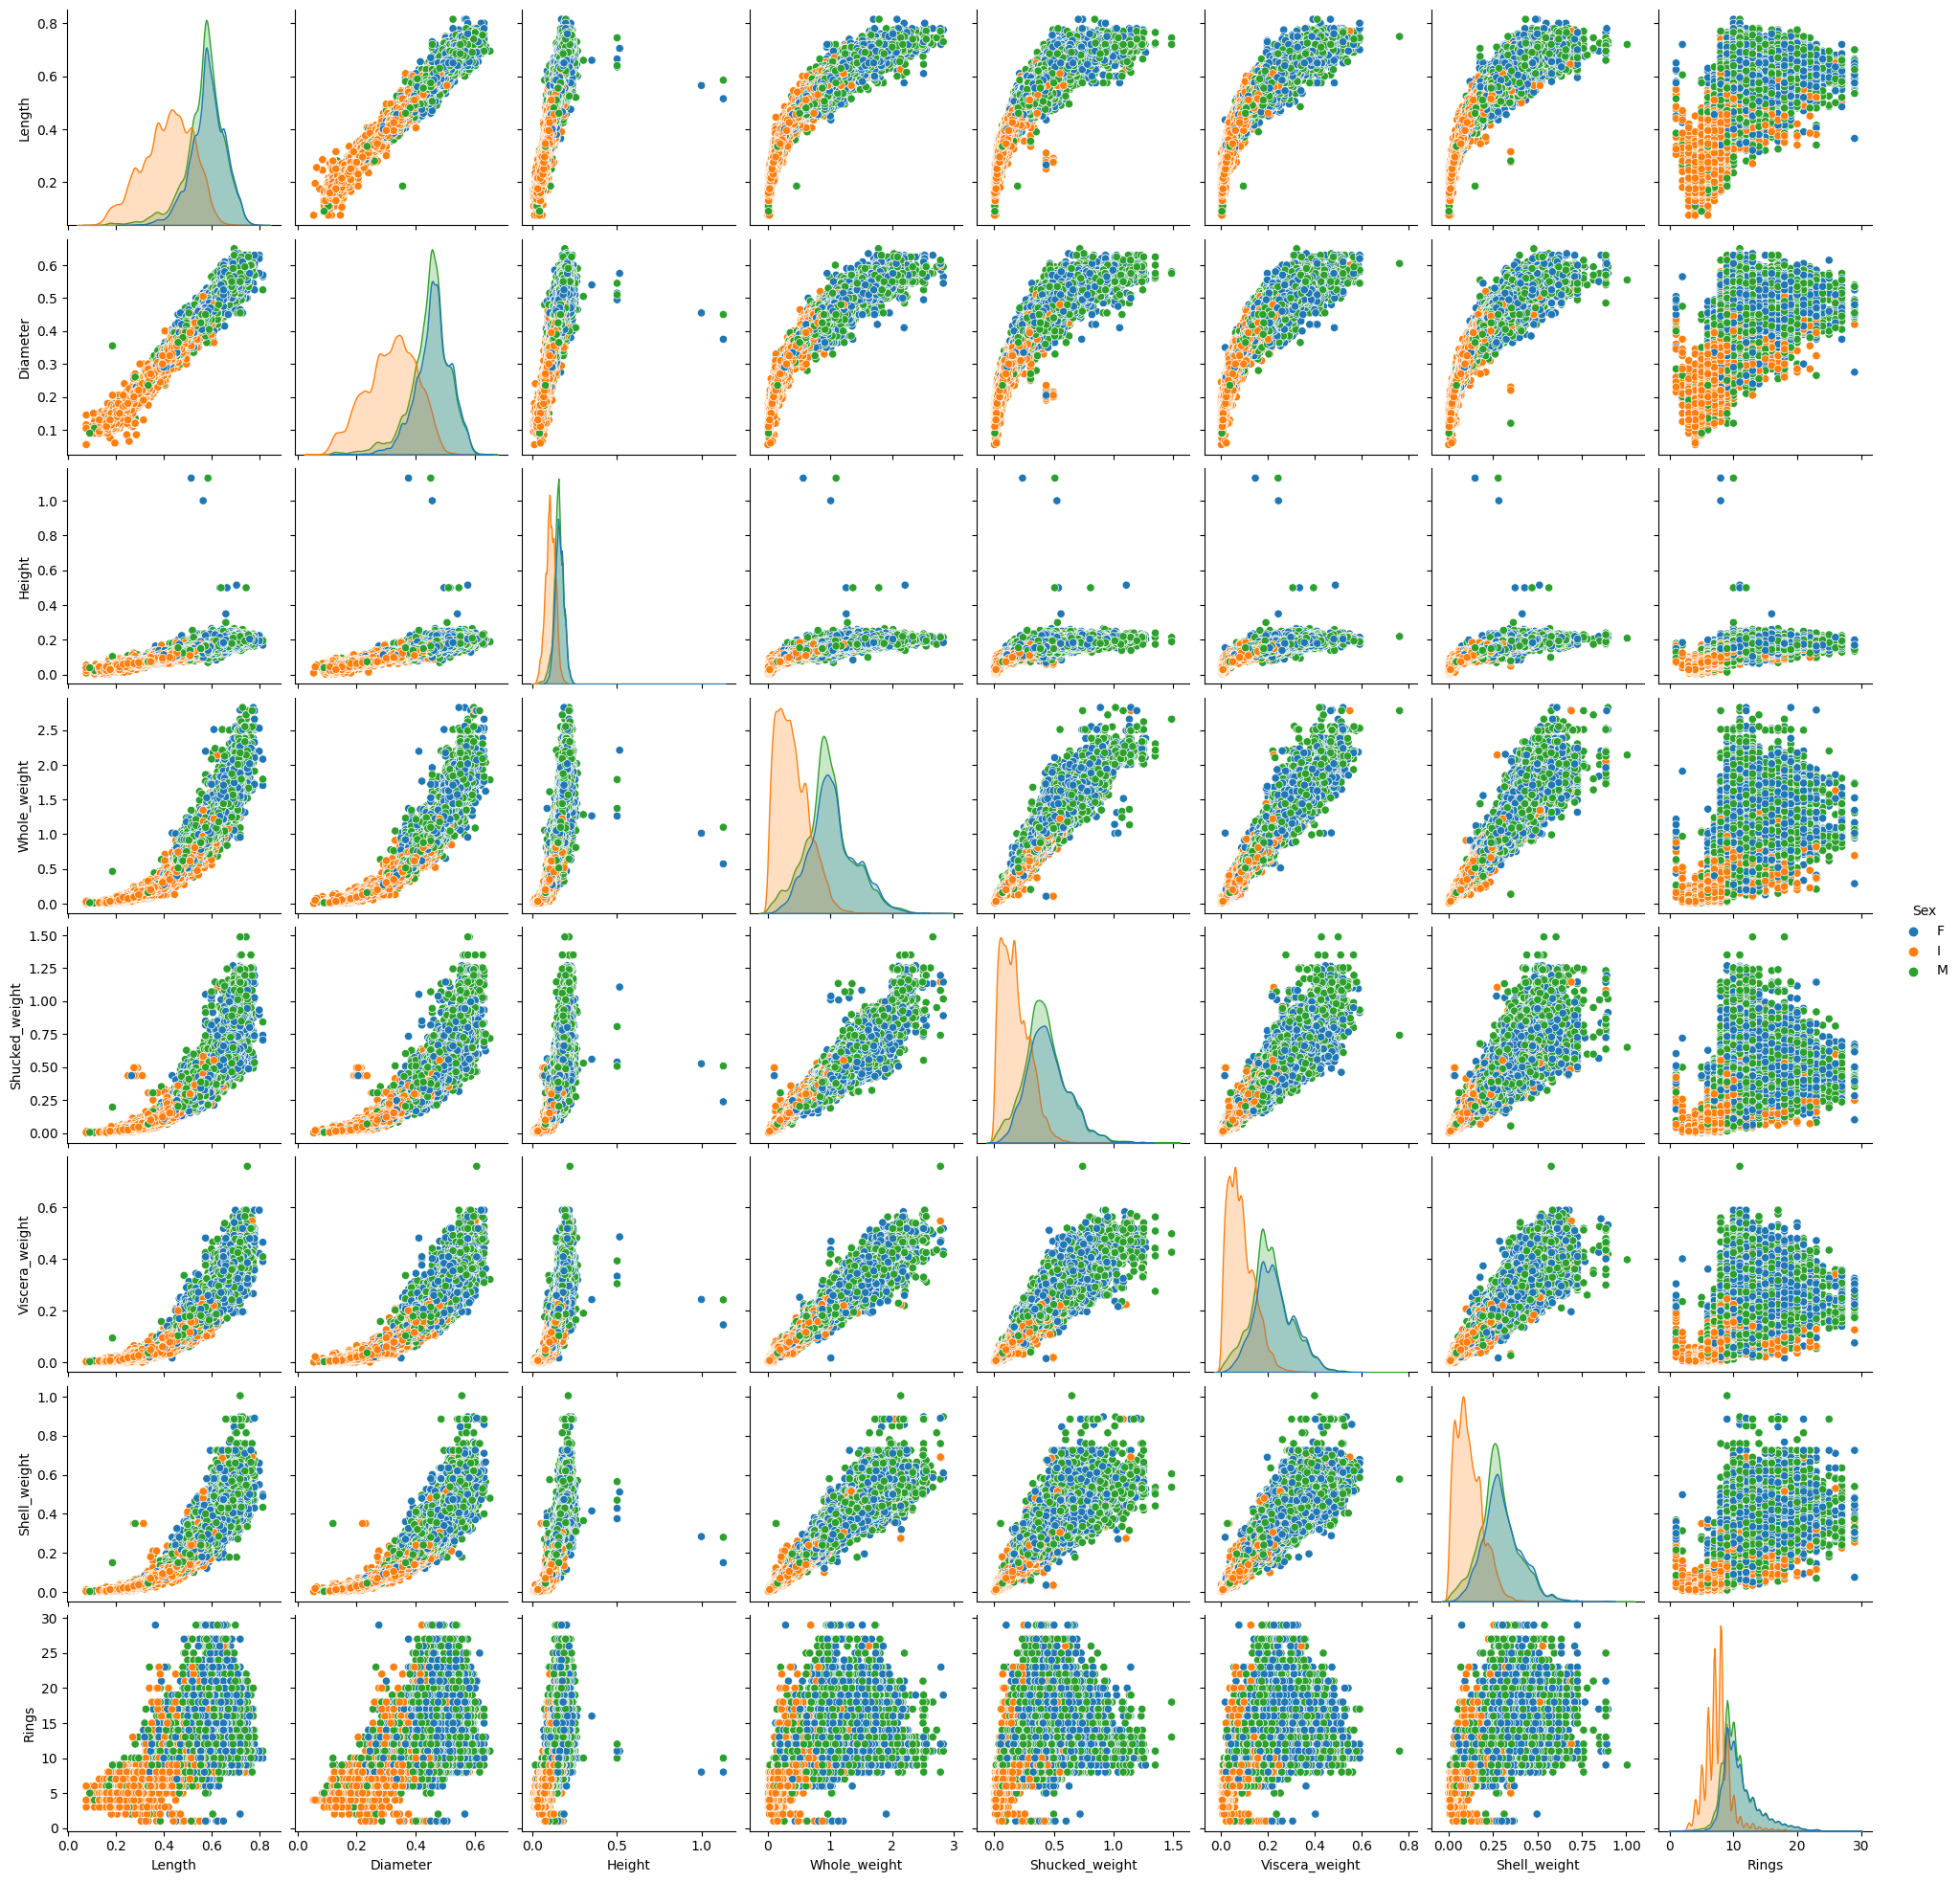

In [16]:
cont_cols = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
target = ['Rings']
sns.pairplot(data=train, vars=cont_cols+target, hue='Sex')
plt.show()

## 5.4 Look at scatter plots with linear regression lines of variables vs rings 

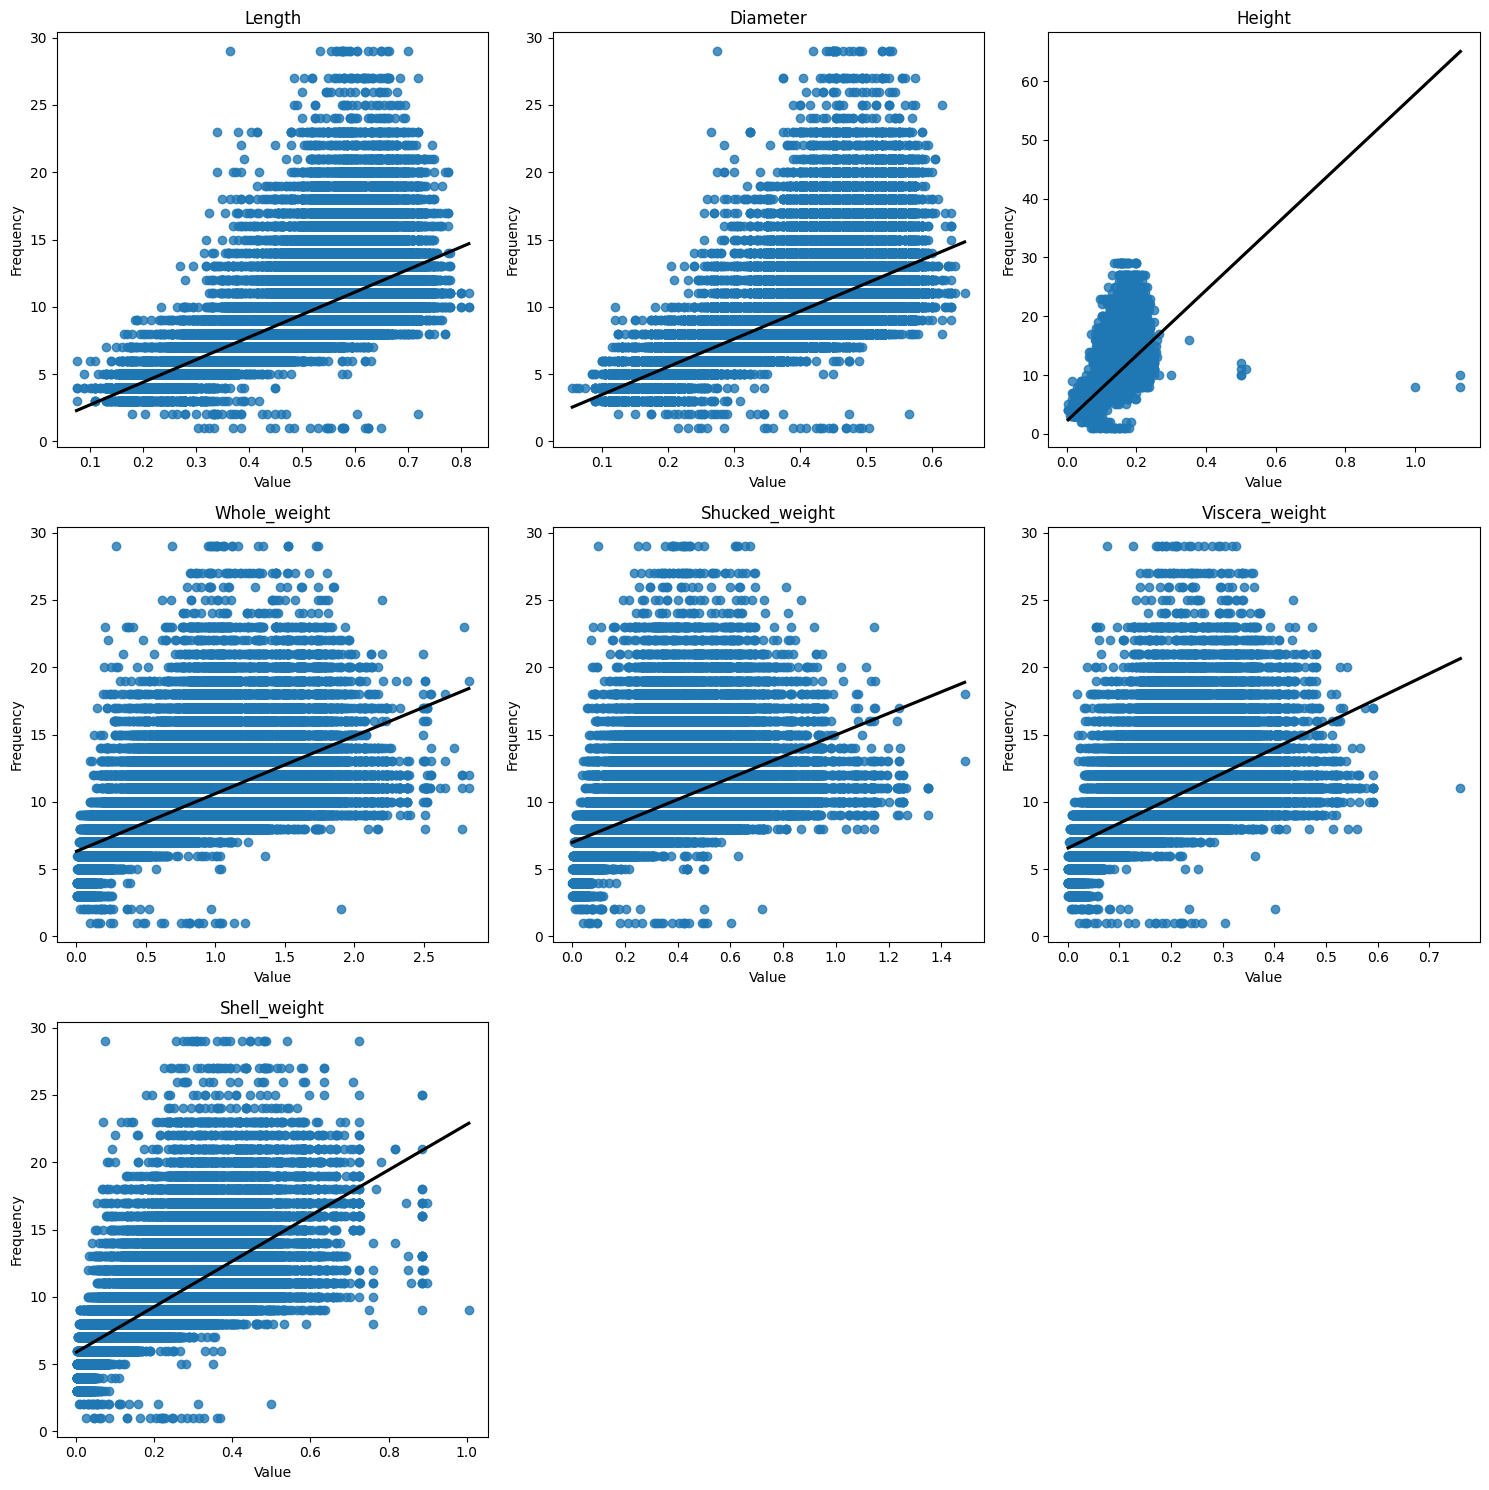

In [17]:
cont_cols = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

# Calculate the number of rows needed for the subplots
num_rows = (len(cont_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Loop through each continuous column and plot the regression plots
for i, col in enumerate(cont_cols):
  
    # Calculate the subplot position
    row = i // 3
    col_pos = i % 3
    
    #create the plot
    sns.regplot( data=train[col], x= train[col] , y= train['Rings'], ci=False, line_kws={'color': 'black'}, ax=axs[row][col_pos])
    axs[row][col_pos].set_title(col)
    axs[row][col_pos].set_xlabel('Value')
    axs[row][col_pos].set_ylabel('Frequency')

        # Remove any empty subplots
if len(cont_cols) % 3 != 0:
    for col_pos in range(len(cont_cols) % 3, 3):
        axs[-1][col_pos].remove()

plt.tight_layout()
plt.show()


## 5.5 Look at the rings compared the the sex 

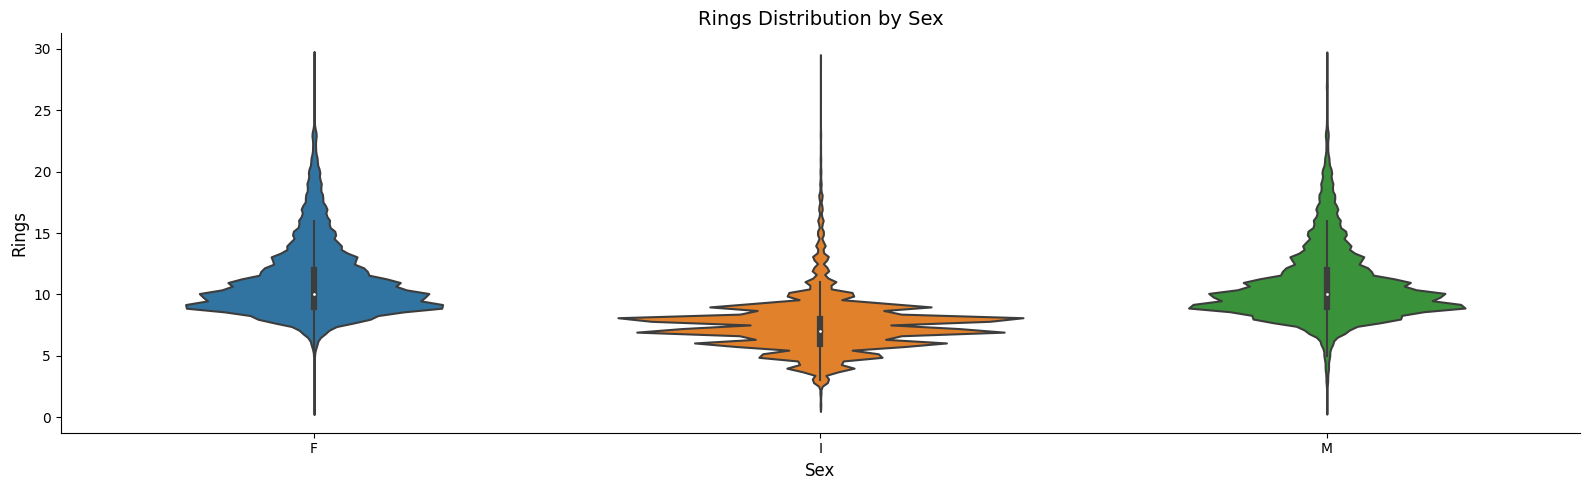

In [18]:
plt.subplots(figsize=(16, 5))
sns.violinplot(x='Sex', y='Rings', data=train)
plt.title('Rings Distribution by Sex', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Rings', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

## 5.6 Create a coorelation plot for all variables 

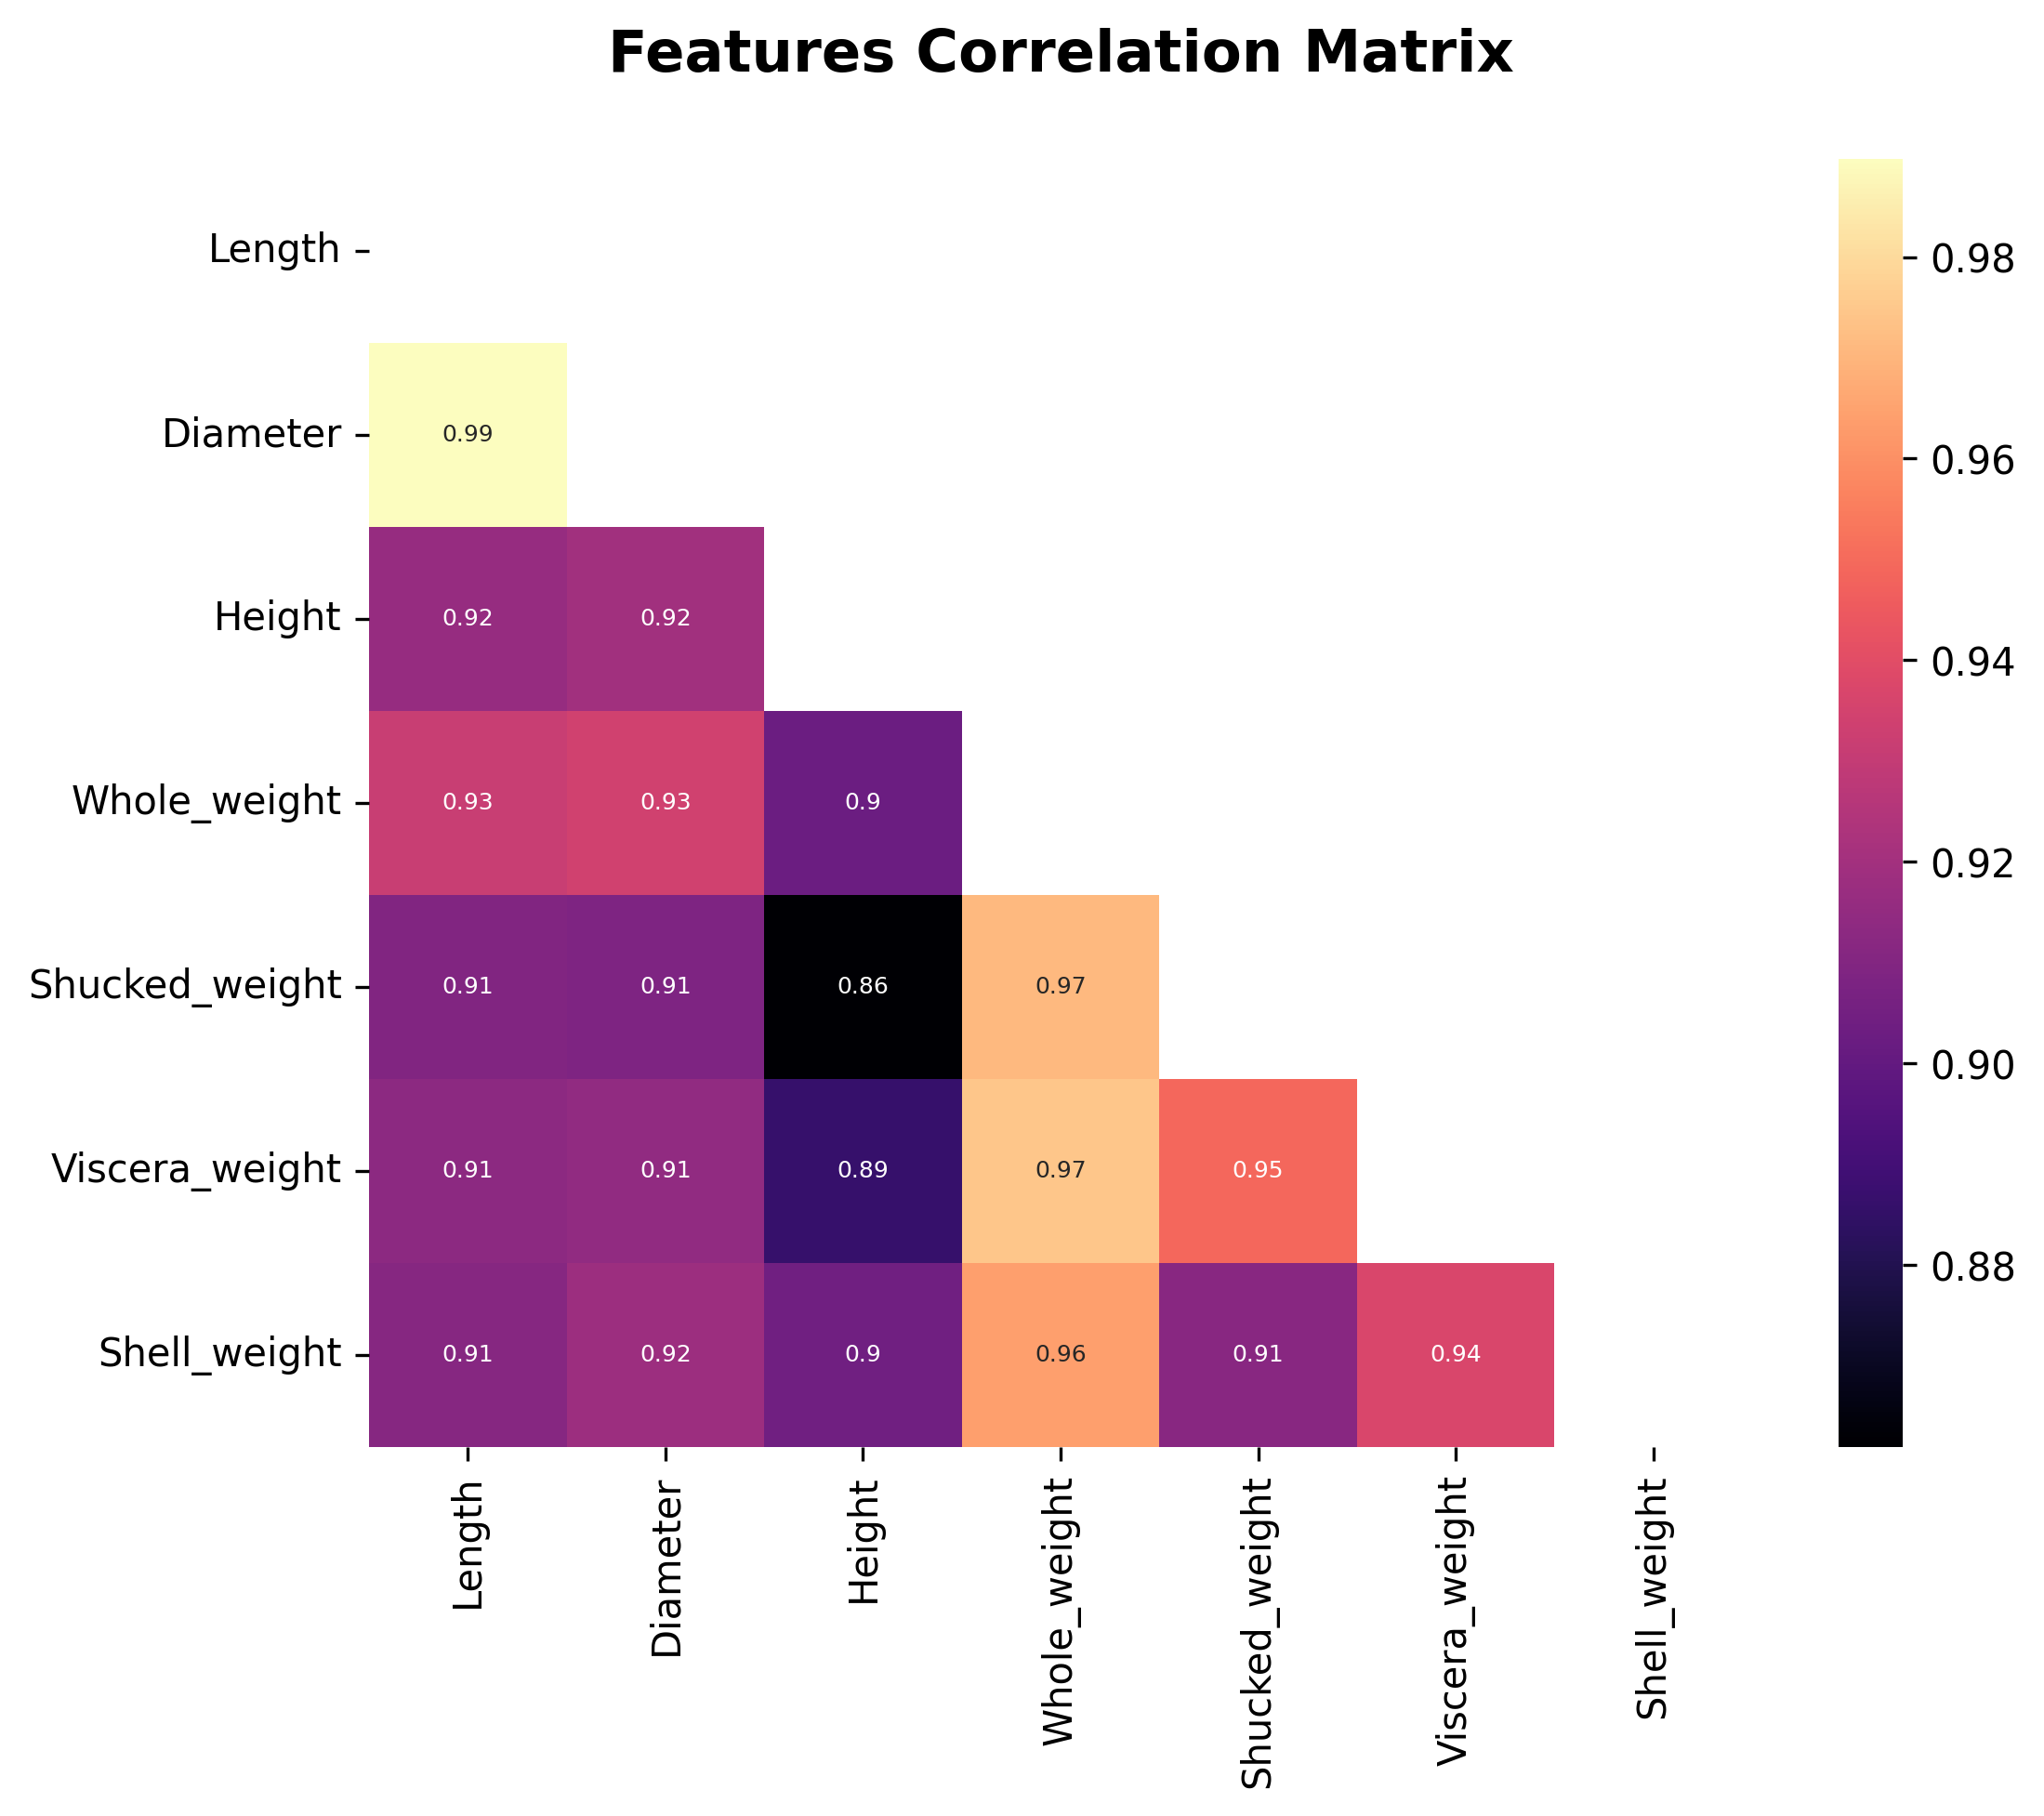

In [19]:
features= predict_col
corr = train[features].corr()
plt.figure(figsize = (8, 6), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'magma', annot = True, annot_kws = {'size' : 6})
plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
plt.show()

# 6. INFERENCES
1. <font size="3"> Both datasets follow the same distributions making the train data a good fit to train a model on. 
2. <font size="3"> There are normal growth lines of the Abalone as seen in these plots. </font>
3. <font size="3">There are some outliers in the data likely because they are not an actual Abalone and that would account for the reason some of these points are saying that they are either much heavier or weigh a lot more. 
4. <font size="3"> Sex seems to show a difference more so when looking at the infant Abalone. </font>
5. <font size="3"> There is a correlation between weights which is expected since the weights are based on variations of the same Abalone and between length & diameter since length would be a value used to get diameter. Other high correlations are still above 89 which is also highly correlated.


# 7. Explore Regression Models

## 7.1 Split dataset for train, validate, test datasets

In [20]:
# Use same target for both models
y = train[['Rings']]

# For full MLR (all numeric predictors)
X_full = train[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']]

# For polynomial regression (only 2 features)
X_poly_raw = train[['Whole_weight', 'Height']]
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_poly_raw)

# Split both sets into training and validation
Xf_train, Xf_val, yf_train, yf_val = train_test_split(X_full, y, test_size=0.2, random_state=42)
Xp_train, Xp_val, yp_train, yp_val = train_test_split(X_poly, y, test_size=0.2, random_state=42)

## 7.2 Full MLR diagnostics and assumptions check 

In [21]:
# Add constant to X for intercept
X_ols = sm.add_constant(X_full)
ols_model = sm.OLS(y, X_ols).fit()

# Summary output with coefficients, p-values, R², etc.
print("=== OLS Summary (Full MLR) ===")
print(ols_model.summary())

=== OLS Summary (Full MLR) ===
                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                 1.937e+04
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        02:38:20   Log-Likelihood:            -1.9184e+05
No. Observations:               90609   AIC:                         3.837e+05
Df Residuals:                   90601   BIC:                         3.838e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const        

In [22]:
print("\n=== Variance Inflation Factors ===")
vif_data = pd.DataFrame()
vif_data["Feature"] = X_full.columns
vif_data["VIF"] = [variance_inflation_factor(X_full.values, i) for i in range(X_full.shape[1])]
print(vif_data)


=== Variance Inflation Factors ===
          Feature         VIF
0          Length  895.057206
1        Diameter  957.423171
2          Height  103.956871
3    Whole_weight  270.648436
4  Shucked_weight   80.216406
5  Viscera_weight   75.811852
6    Shell_weight   71.831180


In [23]:
# Predict and get residuals
y_pred_ols = ols_model.predict(X_ols)
resid_ols = y.values.flatten() - y_pred_ols

# Durbin-Watson for autocorrelation
dw_stat = durbin_watson(resid_ols)
print(f"\nDurbin-Watson statistic: {dw_stat:.4f}")

# Normality tests
shapiro_stat, shapiro_p = shapiro(resid_ols)
print(f"Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p={shapiro_p:.4f}")

jb_stat, jb_p = jarque_bera(resid_ols)
print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p={jb_p:.4f}")


Durbin-Watson statistic: 1.9972
Shapiro-Wilk test: statistic=0.8925, p=0.0000
Jarque-Bera test: statistic=196437.3233, p=0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 90609.
  res = hypotest_fun_out(*samples, **kwds)


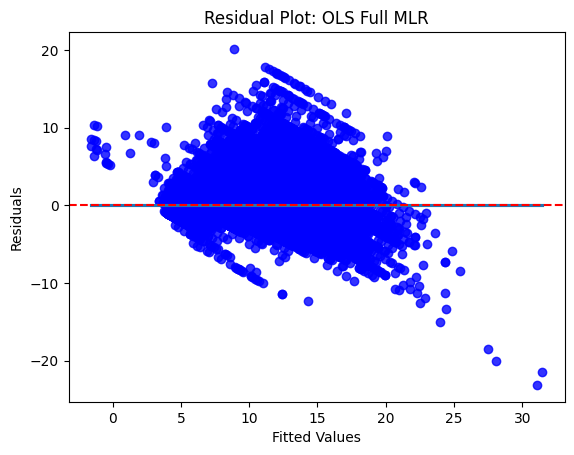

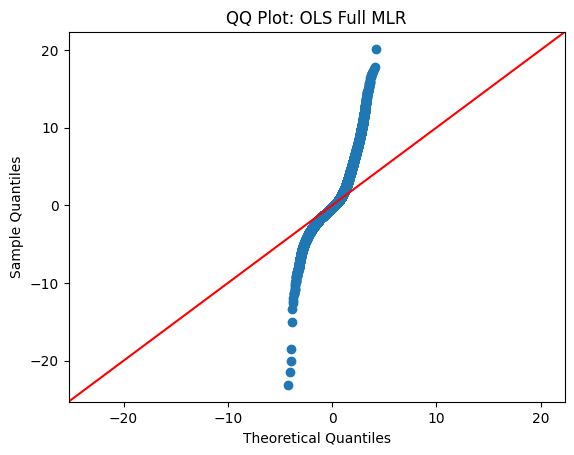

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


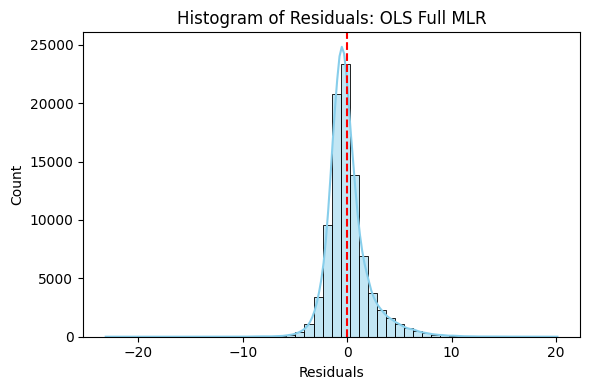

In [24]:
# Residual vs. Fitted plot
sns.regplot(x=y_pred_ols, y=resid_ols, ci=False, scatter_kws={'color': 'blue'})
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot: OLS Full MLR')
plt.show()

# QQ plot for residual normality
sm.qqplot(resid_ols, line='45')
plt.title('QQ Plot: OLS Full MLR')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
sns.histplot(resid_ols, bins=50, kde=True, color='skyblue')
plt.title("Histogram of Residuals: OLS Full MLR")
plt.xlabel("Residuals")
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

## 7.2 Start Multiple linear regression with all continuous predictors 

In [25]:
# Fit model
full_model = LinearRegression()
full_model.fit(Xf_train, yf_train)

# Predict
yf_pred = full_model.predict(Xf_val)

# Residuals
resid_f = yf_val.values - yf_pred

# Evaluation
print("FULL MLR EVALUATION")
print("R²:", full_model.score(Xf_val, yf_val))
print("RMSE:", np.sqrt(mean_squared_error(yf_val, yf_pred)))
print("RMSLE:", np.sqrt(mean_squared_log_error(yf_val, np.clip(yf_pred, a_min=0, a_max=None))))

FULL MLR EVALUATION
R²: 0.592208804570217
RMSE: 2.029168910897
RMSLE: 0.16712472005950882


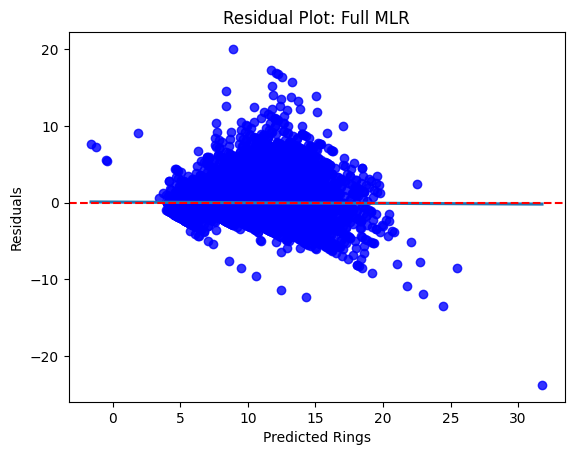

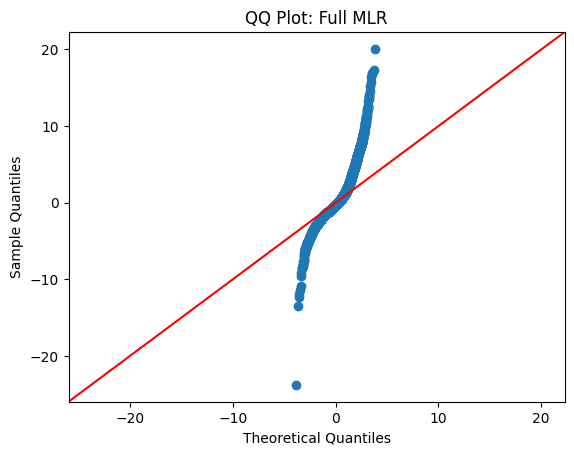

In [26]:
# Residuals plot
sns.regplot(x=yf_pred, y=resid_f, ci=False, scatter_kws={'color': 'blue'})
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Rings')
plt.ylabel('Residuals')
plt.title('Residual Plot: Full MLR')
plt.show()

# QQ plot
sm.qqplot(np.ravel(resid_f), line='45')
plt.title('QQ Plot: Full MLR')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

## 7.3 Start Polynomial Regression 

In [27]:
# Fit model
poly_model = LinearRegression()
poly_model.fit(Xp_train, yp_train)

# Predict
yp_pred = poly_model.predict(Xp_val)

# Residuals
resid_p = yp_val.values - yp_pred

# Evaluation
print("POLYNOMIAL REGRESSION EVALUATION")
print("R²:", poly_model.score(Xp_val, yp_val))
print("RMSE:", np.sqrt(mean_squared_error(yp_val, yp_pred)))
print("RMSLE:", np.sqrt(mean_squared_log_error(yp_val, np.clip(yp_pred, a_min=0, a_max=None))))

POLYNOMIAL REGRESSION EVALUATION
R²: 0.45570395597626046
RMSE: 2.344319858201149
RMSLE: 0.18705015954695392


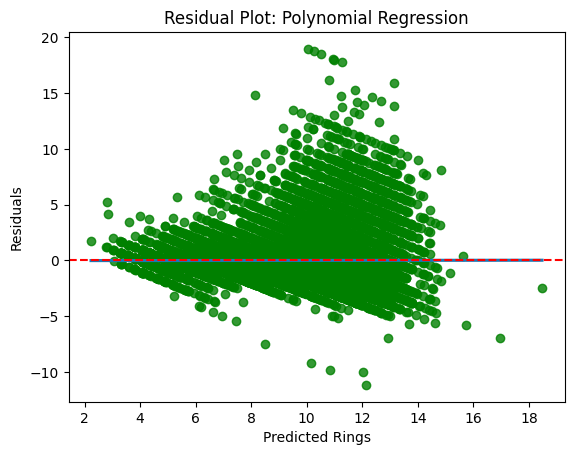

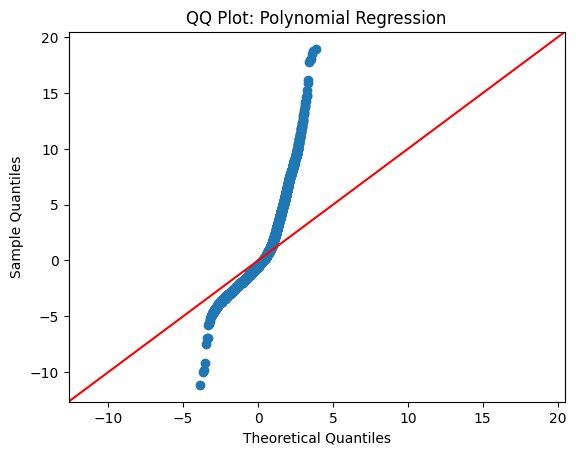

In [28]:
# Residuals plot
sns.regplot(x=yp_pred, y=resid_p, ci=False, scatter_kws={'color': 'green'})
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Rings')
plt.ylabel('Residuals')
plt.title('Residual Plot: Polynomial Regression')
plt.show()

# QQ plot
sm.qqplot(np.ravel(resid_p), line='45')
plt.title('QQ Plot: Polynomial Regression')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

## 7.4 Compare models 

In [29]:
print("Comparison of Evaluation Metrics")
print("--------------------------------")
print("FULL MLR")
print(f"R²     : {full_model.score(Xf_val, yf_val):.4f}")
print(f"RMSE   : {np.sqrt(mean_squared_error(yf_val, yf_pred)):.4f}")
print(f"RMSLE  : {np.sqrt(mean_squared_log_error(yf_val, np.clip(yf_pred, a_min=0, a_max=None))):.4f}")
print("\nPOLYNOMIAL REGRESSION")
print(f"R²     : {poly_model.score(Xp_val, yp_val):.4f}")
print(f"RMSE   : {np.sqrt(mean_squared_error(yp_val, yp_pred)):.4f}")
print(f"RMSLE  : {np.sqrt(mean_squared_log_error(yp_val, np.clip(yp_pred, a_min=0, a_max=None))):.4f}")


Comparison of Evaluation Metrics
--------------------------------
FULL MLR
R²     : 0.5922
RMSE   : 2.0292
RMSLE  : 0.1671

POLYNOMIAL REGRESSION
R²     : 0.4557
RMSE   : 2.3443
RMSLE  : 0.1871


# 8. Hot Encode and Prepare Data for Regularization 

In [30]:
# 1. One-hot encode 'Sex'
train_encoded = pd.get_dummies(train, columns=['Sex'], drop_first=False)
test_encoded = pd.get_dummies(test, columns=['Sex'], drop_first=False)

# Ensure all Sex categories exist
for col in ['Sex_F','Sex_M','Sex_I']:
    if col not in train_encoded.columns:
        train_encoded[col] = 0
    if col not in test_encoded.columns:
        test_encoded[col] = 0

# 2. Feature Engineering
eps = 1e-6
def engineer_features(df):
    df['meat_ratio'] = df['Shucked_weight'] / (df['Whole_weight'] + eps)
    df['viscera_ratio'] = df['Viscera_weight'] / (df['Whole_weight'] + eps)
    df['shell_ratio'] = df['Shell_weight'] / (df['Whole_weight'] + eps)
    df['meat_to_shell_ratio'] = df['Shucked_weight'] / (df['Shell_weight'] + eps)
    df['viscera_to_meat_ratio'] = df['Viscera_weight'] / (df['Shucked_weight'] + eps)
    df['volume'] = df['Length'] * df['Diameter'] * df['Height']
    df['density'] = df['Whole_weight'] / (df['volume'] + eps)
    df['log_whole_weight'] = np.log(df['Whole_weight'] + eps)
    return df

train_encoded = engineer_features(train_encoded)
test_encoded = engineer_features(test_encoded)

# 3. Align test columns
for c in set(train_encoded.columns) - set(test_encoded.columns) - {'Rings'}:
    test_encoded[c] = 0

# 4. Features and target
feature_cols = [c for c in train_encoded.columns if c != 'Rings']
# Convert data to numeric to avoid object dtype issues in statsmodels
train_X = train_encoded[feature_cols].astype(float)
train_y = train_encoded['Rings'].astype(float)
test_X = test_encoded[feature_cols].astype(float)

# 5. Split and scale
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=feature_cols)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=feature_cols)
test_X_scaled = pd.DataFrame(scaler.transform(test_X), columns=feature_cols)


## 8.1 Explore Forward and Backwards Stepwise 

In [31]:

# 6. Forward & Backward Stepwise (AIC)
def forward_stepwise_selection(X, y):
    remaining = list(X.columns)
    selected = []
    current_aic = np.inf
    best_model = None
    while remaining:
        candidates = []
        for cand in remaining:
            model_features = selected + [cand]
            X_m = add_constant(X[model_features])
            m = sm.OLS(y, X_m).fit()
            candidates.append((m.aic, cand, m))
        candidates.sort(key=lambda x: x[0])
        best_aic, best_feat, best_m = candidates[0]
        if best_aic < current_aic:
            remaining.remove(best_feat)
            selected.append(best_feat)
            current_aic = best_aic
            best_model = best_m
        else:
            break
    return best_model, selected

def backward_stepwise_selection(X, y):
    features = list(X.columns)
    current_model = sm.OLS(y, add_constant(X)).fit()
    current_aic = current_model.aic
    best_model = current_model
    while len(features) > 1:
        candidates = []
        for feat in features:
            reduced = [f for f in features if f != feat]
            m = sm.OLS(y, add_constant(X[reduced])).fit()
            candidates.append((m.aic, feat, m))
        candidates.sort(key=lambda x: x[0])
        best_aic, worst_feat, best_m = candidates[0]
        if best_aic < current_aic:
            features.remove(worst_feat)
            current_aic = best_aic
            best_model = best_m
        else:
            break
    return best_model, features

# Run stepwise selection
fwd_model, fwd_features = forward_stepwise_selection(train_X, train_y)
bwd_model, bwd_features = backward_stepwise_selection(train_X, train_y)

print("Selected predictors (forward):", fwd_features)
print(fwd_model.summary())
print("      ")
print("      ")
print("Selected predictors (backward):", bwd_features)
print(bwd_model.summary())

Selected predictors (forward): ['Shell_weight', 'Shucked_weight', 'log_whole_weight', 'Sex_I', 'Height', 'Length', 'Whole_weight', 'volume', 'Viscera_weight', 'viscera_to_meat_ratio', 'meat_ratio', 'viscera_ratio', 'Diameter', 'shell_ratio', 'meat_to_shell_ratio', 'density']
                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     9258.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        02:38:38   Log-Likelihood:            -1.8939e+05
No. Observations:               90609   AIC:                         3.788e+05
Df Residuals:                   90592   BIC:                         3.790e+05
Df Model:                          16                                         
Covariance Ty

## 8.2 Fit Regularization Models (Lasso, Ridge, ElasticNet)

In [32]:
lasso= LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
ridge= RidgeCV(alphas=np.logspace(-4,4,100), cv=5).fit(X_train_scaled, y_train)
elastic= ElasticNetCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

# Predictions
y_pred = {
    'Lasso': lasso.predict(X_val_scaled),
    'Ridge': ridge.predict(X_val_scaled),
    'ElasticNet': elastic.predict(X_val_scaled)
}

## 8.3 Fit Principal Components Regression (PCR)

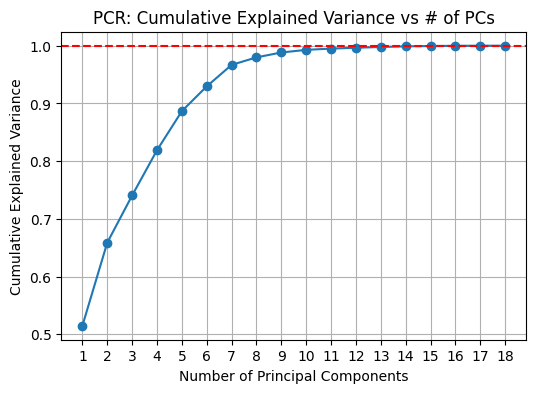

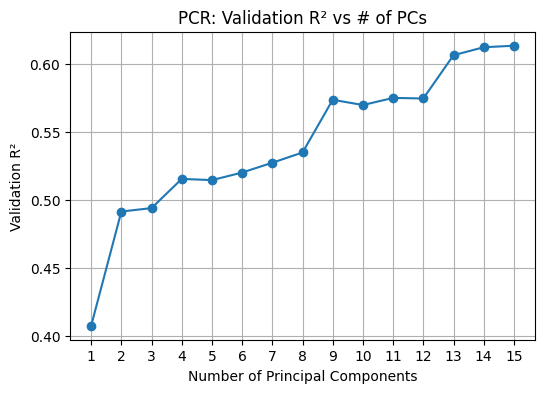

In [33]:
# PCA instantiation with all features
dimensions = len(feature_cols)
pca = PCA(n_components=dimensions)

# Fit PCA on scaled training data
pca.fit(X_train_scaled)

# Cumulative explained variance plot
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, dimensions+1), explained, marker='o')
plt.axhline(1.0, color='red', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCR: Cumulative Explained Variance vs # of PCs')
plt.xticks(range(1, dimensions+1))
plt.grid(True)
plt.show()

# Validation R² vs number of PCs
max_pcs = min(15, dimensions)
r2_vals = []
for k in range(1, max_pcs+1):
    pca_k = PCA(n_components=k)
    X_pca_k = pca_k.fit_transform(X_train_scaled)
    Xv_pca_k = pca_k.transform(X_val_scaled)
    lr_k = LinearRegression().fit(X_pca_k, y_train)
    r2_vals.append(r2_score(y_val, lr_k.predict(Xv_pca_k)))

plt.figure(figsize=(6,4))
plt.plot(range(1, max_pcs+1), r2_vals, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Validation R²')
plt.title('PCR: Validation R² vs # of PCs')
plt.xticks(range(1, max_pcs+1))
plt.grid(True)
plt.show()

In [34]:
pca= PCA(n_components=14)
X_pca= pca.fit_transform(X_train_scaled)
Xv_pca= pca.transform(X_val_scaled)
lr_pcr= LinearRegression().fit(X_pca,y_train)
y_pred['PCR']= lr_pcr.predict(Xv_pca)

## 8.4 Review Model Performance 

In [35]:
# Lasso OLS Summary
lasso_feats = list(pd.Series(lasso.coef_, index=train_X.columns)[lambda s: s!=0].index)
X_lasso = add_constant(train_X[lasso_feats])
model_lasso = sm.OLS(train_y, X_lasso).fit()


# Ridge OLS Summary
ridge_coefs = pd.Series(ridge.coef_, index=train_X.columns).abs().sort_values(ascending=False).head(10).index.tolist()
X_ridge = add_constant(train_X[ridge_coefs])
model_ridge = sm.OLS(train_y, X_ridge).fit()


# ElasticNet OLS Summary
elastic_feats = list(pd.Series(elastic.coef_, index=train_X.columns)[lambda s: s!=0].index)
X_elastic = add_constant(train_X[elastic_feats])
model_elastic = sm.OLS(train_y, X_elastic).fit()


# PCR OLS Summary (first 3 PCs)
pca3 = PCA(n_components=3)
X_pca3_train = pca3.fit_transform(X_train_scaled)
X_pca3_df = pd.DataFrame(X_pca3_train, columns=[f"PC{i+1}" for i in range(3)], index=X_train.index)
# Fit OLS on the full training split's PCR features
X_pca3_const = add_constant(X_pca3_df)
model_pcr = sm.OLS(y_train, X_pca3_const).fit()  

In [36]:
summary=[]
for m, pred in y_pred.items():
    summary.append({
        'Model': m,
        'R2': r2_score(y_val,pred),
        'RMSE': np.sqrt(mean_squared_error(y_val,pred)),
        'RMSLE': np.sqrt(mean_squared_log_error(y_val,np.clip(pred,0,None)))
    })
df_summary=pd.DataFrame(summary)



# 10. Display
print(" ======================== Forward Stepwise ========================")
print(fwd_model.summary())
print("      ")
print("\n ========================Backward Stepwise ========================")
print(bwd_model.summary())
print("\n")
print("\n======================== Model Comparison Summary ========================")
print(df_summary)
print("\n")
print("======================== Lasso OLS Summary ========================")
print(model_lasso.summary())
print("\n")
print("======================== Ridge OLS Summary ========================")
print(model_ridge.summary())
print("\n")
print("======================== ElasticNet OLS Summary ========================")
print(model_elastic.summary())
print("\n")
print("========================PCR OLS Summary ========================")
print(model_pcr.summary())



 ======================== Forward Stepwise ========================
                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     9258.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):               0.00
Time:                        02:38:55   Log-Likelihood:            -1.8939e+05
No. Observations:               90609   AIC:                         3.788e+05
Df Residuals:                   90592   BIC:                         3.790e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

## 8.5 Review Plots and Assumptions for Ridge

/tmp/ipykernel_13/235924403.py:43: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=',', use_line_collection=True)


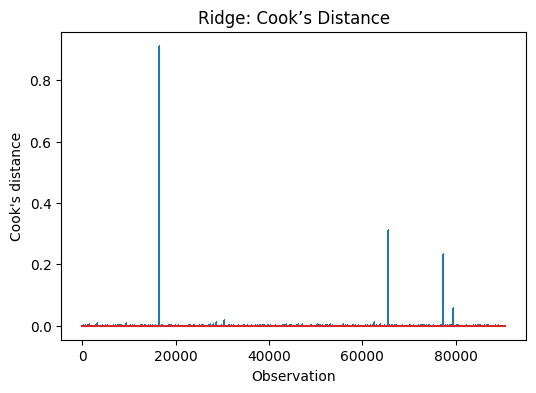

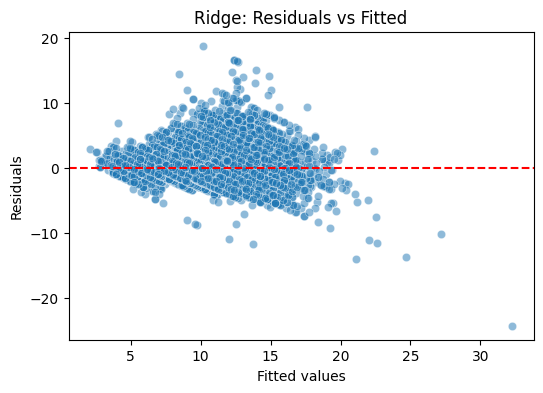

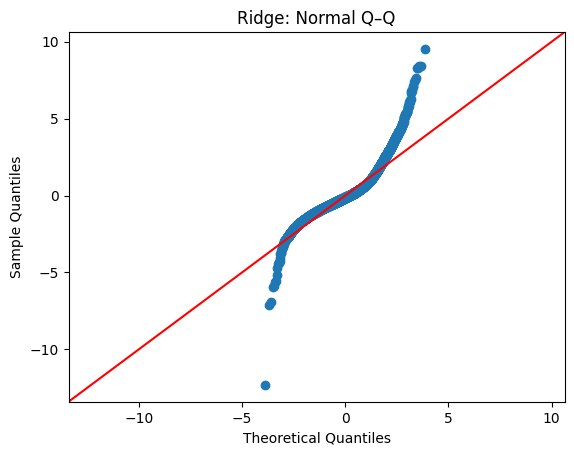

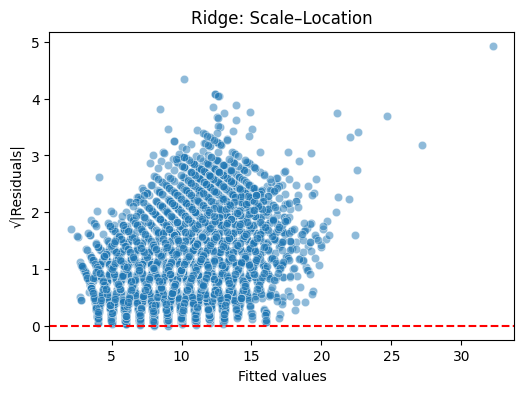

In [37]:
# Refit OLS ridge subset for diagnostics:
ridge_feats = pd.Series(ridge.coef_, index=train_X.columns).abs().sort_values(ascending=False).head(10).index.tolist()
X_ridge = add_constant(train_X[ridge_feats])
ridge_ols = sm.OLS(train_y, X_ridge).fit()

y_pred_ridge = ridge_ols.predict(X_ridge)
resid = train_y - y_pred_ridge

# 1. Residuals vs Fitted
def plot_resid_vs_fitted(y_true, y_pred):
    resid = y_true - y_pred
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_pred, y=resid, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title('Ridge: Residuals vs Fitted')
    plt.show()

# 2. QQ Plot
def plot_qq(y_true, y_pred):
    resid = y_true - y_pred
    sm.qqplot(resid, line='45', fit=True)
    plt.title('Ridge: Normal Q–Q')
    plt.show()

# 3. Scale-Location
def plot_scale_location(y_true, y_pred):
    resid = y_true - y_pred
    sqrt_abs_resid = np.sqrt(np.abs(resid))
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_pred, y=sqrt_abs_resid, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('√|Residuals|')
    plt.title('Ridge: Scale–Location')
    plt.show()

# 4. Cook's Distance
influence = OLSInfluence(ridge_ols)
(cooks_d, p) = influence.cooks_distance
plt.figure(figsize=(6,4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=',', use_line_collection=True)
plt.xlabel('Observation')
plt.ylabel("Cook's distance")
plt.title('Ridge: Cook’s Distance')
plt.show()

# Run plots
y_pred_val = ridge.predict(X_val_scaled)
plot_resid_vs_fitted(y_val, y_pred_val)
plot_qq(y_val, y_pred_val)
plot_scale_location(y_val, y_pred_val)

# 9. Submit results 

In [38]:
submission = pd.DataFrame({'id': test['id'], 'Rings': np.round(np.clip(ridge.predict(test_X_scaled),0,None)).astype(int)})
submission.to_csv('/kaggle/working/submission_ridge.csv', index=False)
print('Exported submission_ridge.csv')


Exported submission_ridge.csv
